This was a homework assignment to create a classifier that predicts whether passengers on the Titatnic survived or not depending on various data features, guided by the instructions below:

Assignment 3, Part 1: Data Exploration. Load the training csv from the Kaggle
Titanic dataset into a pandas dataframe. Document the columns that are missing
data both numerically (via a count) and visually (via an sns heatmap). Document
which values are categorical. Explore the data and answer the following
questions: Did more women or men die on the Titanic? Which passenger class
was more likely to survive? What does the distribution of fare look like? What
does the distribution of non-null age values look like? What is the median age of
each passenger class (pclass)? Visualize this in a box plot.
● Assignment 3, Part 2: Data Cleansing. Since there are so many missing values
in Cabin, get rid of the cabin feature. Define a function to impute age using the
median of the passenger class you computed earlier. To call it, use train[[‘Age’,
‘Pclass]].apply(impute_age,axis=1). Drop the remaining records containing null
values. Show there are no remaining null values. Convert categorical variables to
numeric dummies using pandas’ get_dummies() method. Add these to your
training dataframe. Drop the categorical columns you converted earlier as well as
Name, Ticket, and PassengerId. Create a feature set by dropping “Survived.”
Your resulting feature set should include Pclass, Age, SibSp, Parch, Fare, and
the categorical dummy columns you created earlier. Implement a label dataframe
by copying the contents of the Survived column of your training set to a new
dataframe.
● Assignment 3, Part 3: Model Training. Implement a logistic regression model.
Implement a support vector classifier. Implement an sgd classifier. Print out the
classification reports, confusion matrices, and roc score and chart for each of
these. Remember to set Probability=True for SVM and use
method=decision_function in a cross_val_predict instead of predict_proba for the
SGD ROC plot.
● Assignment 3, Part 4: Model Tuning
o See if scaling your input data affects your SVC model (implement a
sklearn pipeline to combine scaling and instantiation of your model).
o Do a grid search of your pipeline classifier using the following parameter
grid: {‘linear_svc__kernel’: [‘rbf’], ‘linear_svc__gamma’: [0.0001, 0.001,
0.01, 0.1, 1], ‘linear_svc__C’: [1,10,50,100,200,300]}.
o Print the best estimator, its parameters, and the resulting score.
o Implement a learning curve using your best estimator from the grid search.
▪ The figure should have a title of “learning curve.”
▪ Label the y-axis with “Score.”
▪ Label the x-axis with “Training Examples.”
▪ Make the training score red.
▪ Make the validation score green.
▪ What does this learning curve tell you?

In [1]:
#!pip install scikit-plot

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
import pickle
#import scikitplot as skplt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.svm import LinearSVC
import scikitplot as skplt
from sklearn.model_selection import learning_curve
import pickle

# Part 1

In [3]:
'''
Survived: 0 = No, 1 = Yes
Pclass: 1, 2, 3 ticket class; likely indicator of socioeconomic status. Potentially categorical.
Name, string
Sex, string. Categorical.
Age, int years
SibSp: # of siblings or spouses on board
Parch: # of parents or children on board
Ticket: String printed on ticket
Fare: price of ticket
Cabin: # of cabin occupied by passenger
Embarked: Port where passenger boarded Titanic. Categorical.
'''

train = pd.read_csv("C:/JupyterNotebookStuff/titanic_train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:>

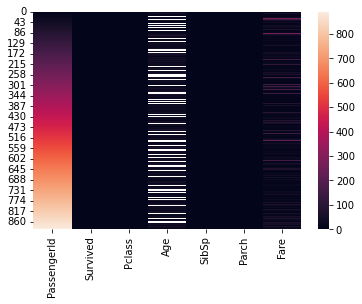

In [5]:
numerics = train[['PassengerId', 'Survived', 'Pclass', 'Age','SibSp','Parch','Fare']]
sns.heatmap(numerics)

In [6]:
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

There were more male than female passengers.

In [7]:
print('Survival rate for Pclass = 1: ', train[(train['Pclass'] == 1) & (train['Survived'] == 1)].shape[0] / train[(train['Pclass'] == 1)].shape[0])
print('Survival rate for Pclass = 2: ', train[(train['Pclass'] == 2) & (train['Survived'] == 1)].shape[0] / train[(train['Pclass'] == 2)].shape[0])
print('Survival rate for Pclass = 3: ', train[(train['Pclass'] == 3) & (train['Survived'] == 1)].shape[0] / train[(train['Pclass'] == 3)].shape[0])

Survival rate for Pclass = 1:  0.6296296296296297
Survival rate for Pclass = 2:  0.47282608695652173
Survival rate for Pclass = 3:  0.24236252545824846


First class passengers had the highest chance of survival.

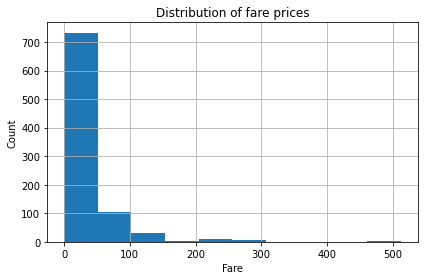

In [8]:
fig, ax = plt.subplots()
ax = train['Fare'].hist()
ax.set_ylabel('Count')
ax.set_xlabel('Fare')
ax.set_title('Distribution of fare prices')
fig.tight_layout()
plt.show()

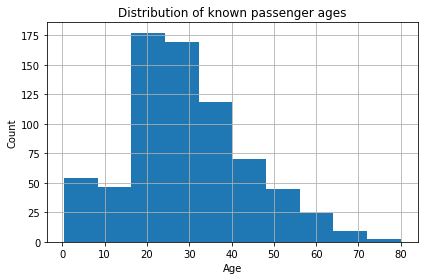

In [9]:
fig, ax = plt.subplots()
ax = train['Age'].dropna().hist()
ax.set_ylabel('Count')
ax.set_xlabel('Age')
ax.set_title('Distribution of known passenger ages')
fig.tight_layout()
plt.show()

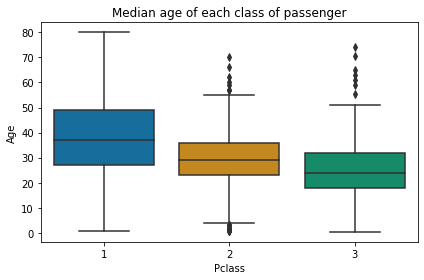

In [10]:
fig, ax = plt.subplots()
ax = sns.boxplot(y='Age', x='Pclass', 
                 data=train, 
                 palette="colorblind")
ax.set_title('Median age of each class of passenger')
fig.tight_layout()
plt.show()

# Part 2

In [11]:
train = train.drop(['Cabin'], axis=1, errors='ignore')

In [12]:
def impute_age(thing):
    if(pd.notnull(thing['Age']) == False):
        if(thing['Pclass'] == 1):
            return p1age
        elif(thing['Pclass'] == 2):
            return p2age
        elif(thing['Pclass'] == 3):
            return p3age
    else:
        return thing['Age']

In [13]:
medians = train.groupby(['Pclass'])['Age'].median()
p1age = medians[1]
p2age = medians[2]
p3age = medians[3]

train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)
train.dropna(inplace = True)
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [14]:
dummies = pd.get_dummies(train[['Sex','Embarked']])
dummies

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1
1,1,0,1,0,0
2,1,0,0,0,1
3,1,0,0,0,1
4,0,1,0,0,1
...,...,...,...,...,...
886,0,1,0,0,1
887,1,0,0,0,1
888,1,0,0,0,1
889,0,1,1,0,0


In [15]:
train = pd.concat([train, dummies], axis = 1)
train.drop(['Sex','Embarked'], axis=1, inplace=True, errors='ignore') # Dropping categorical variables
train.drop(['Name','Ticket','PassengerId'], axis=1, inplace=True, errors='ignore') # Dropping irrelevant variables
train

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,1,19.0,0,0,30.0000,1,0,0,0,1
888,0,3,24.0,1,2,23.4500,1,0,0,0,1
889,1,1,26.0,0,0,30.0000,0,1,1,0,0


In [16]:
X = train.drop(['Survived'], axis=1, errors='ignore')
#X

In [17]:
y = train['Survived']
#y

# Part 3

 Model Training. Implement a logistic regression model.
Implement a support vector classifier. Implement an sgd classifier. Print out the
classification reports, confusion matrices, and roc score and chart for each of
these. Remember to set Probability=True for SVM and use
method=decision_function in a cross_val_predict instead of predict_proba for the
SGD ROC plot.

In [18]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=400)
log_reg.fit(X, y)
log_pred = log_reg.predict(X)
# Classifications
log_pred 

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,

In [19]:
# Confusion Matrix
# tn fp
# fn tp
confusion_matrix(y, log_pred)

array([[476,  73],
       [100, 240]], dtype=int64)

In [20]:
#y_score = log_reg.fit(X, y).decision_function(X)
#y_score

Logistic Regression ROC score:  0.8564046930247509


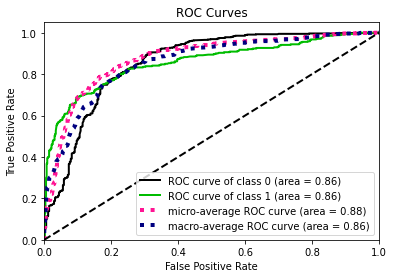

In [21]:
print('Logistic Regression ROC score: ', roc_auc_score(y, log_reg.decision_function(X)))

y_probas = log_reg.predict_proba(X)
skplt.metrics.plot_roc(y, y_probas)
plt.show()

### Support Vector Classifier

In [22]:
# Support Vector Classifier
svc = SVC(probability=True)
svc.fit(X, y)

SVC(probability=True)

In [23]:
svc_pred = svc.predict(X)
svc_pred

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [24]:
confusion_matrix(y, svc_pred)

array([[506,  43],
       [236, 104]], dtype=int64)

Logistic Regression ROC score:  0.7638031715418407


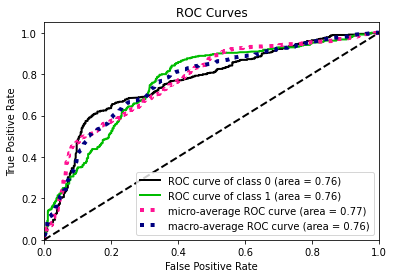

In [25]:
print('Logistic Regression ROC score: ', roc_auc_score(y, svc.decision_function(X)))

y_probas = svc.predict_proba(X)
skplt.metrics.plot_roc(y, y_probas)
plt.show()

In [26]:
y_probas.ndim

2

### SGD Classifier

Remember to set Probability=True for SVM and use method=decision_function in a cross_val_predict instead of predict_proba for the SGD ROC plot.

In [27]:
# Support Vector Classifier
sgd = SGDClassifier()
sgd.fit(X, y)

SGDClassifier()

In [28]:
sgd_pred = sgd.predict(X)

In [29]:
confusion_matrix(y, sgd_pred)

array([[503,  46],
       [137, 203]], dtype=int64)

In [30]:
y_probas = cross_val_predict(sgd, X, y, method='decision_function')

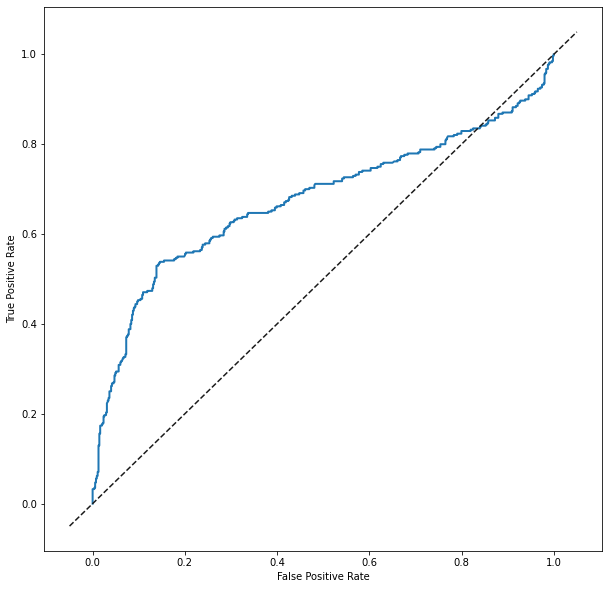

In [31]:
# For some reason this data really didn't like the fancy graph 

fpr, tpr, thresholds = roc_curve(y, y_probas)

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(fpr, tpr, linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".1")
plt.tight_layout;

# Part 4

Assignment 3, Part 4: Model Tuning
o See if scaling your input data affects your SVC model (implement a
sklearn pipeline to combine scaling and instantiation of your model).
o Do a grid search of your pipeline classifier using the following parameter
grid: {‘linear_svc__kernel’: [‘rbf’], ‘linear_svc__gamma’: [0.0001, 0.001,
0.01, 0.1, 1], ‘linear_svc__C’: [1,10,50,100,200,300]}.
o Print the best estimator, its parameters, and the resulting score.
o Implement a learning curve using your best estimator from the grid search.
▪ The figure should have a title of “learning curve.”
▪ Label the y-axis with “Score.”
▪ Label the x-axis with “Training Examples.”
▪ Make the training score red.
▪ Make the validation score green.
▪ What does this learning curve tell you?


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [33]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

In [34]:
param_grid = [ {'svc__kernel': ['rbf'], 'svc__gamma': [0.0001, 0.001,
        0.01, 0.1, 1], 'svc__C': [1,10,50,100,200,300]} ]
grid_search = GridSearchCV(pipe, param_grid, cv=5)
grid_search.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid=[{'svc__C': [1, 10, 50, 100, 200, 300],
                          'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                          'svc__kernel': ['rbf']}])

In [35]:
print('Best params: ')
print(grid_search.best_params_)
print()
print('Best estimator: ')
print(grid_search.best_estimator_)
print()
print('Best score: ')
print(grid_search.best_score_)

Best params: 
{'svc__C': 50, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}

Best estimator: 
Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=50, gamma=0.01))])

Best score: 
0.8245730971878373


In [36]:
good_svc = SVC(probability=True, C=grid_search.best_params_['svc__C'], 
               gamma=grid_search.best_params_['svc__gamma'], kernel=grid_search.best_params_['svc__kernel'])

In [37]:
train_sizes, train_scores, test_scores = learning_curve(good_svc, X, y)

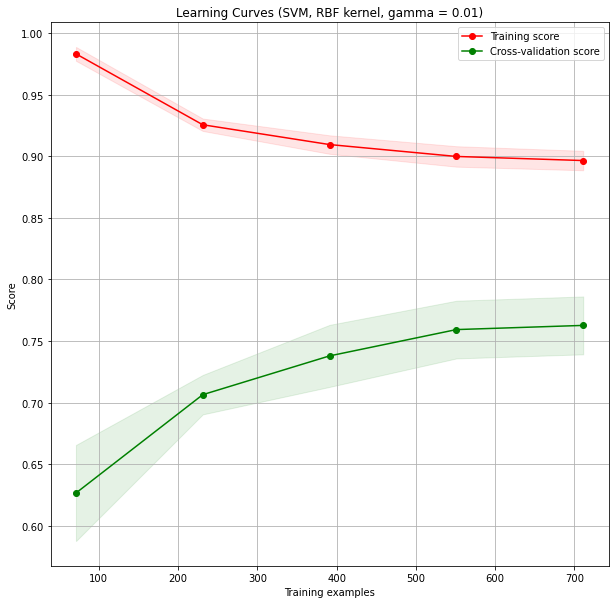

In [38]:
fig, axes = plt.subplots(figsize=(10,10))
axes.set_title('Learning Curves (SVM, RBF kernel, gamma = 0.01)')
axes.set_xlabel("Training examples")
axes.set_ylabel("Score")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
axes.grid()
axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
axes.legend(loc="best")

In [39]:
train.to_pickle("./titanic.pkl")

In [40]:
train

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,1,19.0,0,0,30.0000,1,0,0,0,1
888,0,3,24.0,1,2,23.4500,1,0,0,0,1
889,1,1,26.0,0,0,30.0000,0,1,1,0,0


In [41]:
with open('./titanic.pkl', 'wb') as f:
    train.to_pickle(f)

In [42]:
train.to_pickle('./pickletest.pkl')

In [43]:
pd.read_pickle('./titanic.pkl')

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,1,19.0,0,0,30.0000,1,0,0,0,1
888,0,3,24.0,1,2,23.4500,1,0,0,0,1
889,1,1,26.0,0,0,30.0000,0,1,1,0,0
